In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17; # python -m ipykernel install --user --name=EnvPBGEM_Linux --display-name "Python_Linux"
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
## Global setting: change with PC or HPC
# Path_NiallDMA = "InputData/" # for HPC

# Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/" # for Windows
Path_NiallDMA = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
# BasicPath=os.getcwd() # for HPC
# path for windows's pybamm in office PC 
# BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R9_Dim/Test'  
# for linux pybamm in office pc:
BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

# Set Experiment : Exp-2
index_exp = 2 # index for experiment set, can now go for 2,3,5
Round_No = "debug_Dryout_nondry"  # index to identify different rounds of running 
pool_no = 8
Runshort = False # True

if Runshort == False:
    if index_exp == 2:
        tot_cyc = 6192; cyc_age = 516;
    if index_exp == 3:
        tot_cyc = 6180; cyc_age = 515;
    if index_exp == 5:
        tot_cyc = 1170; cyc_age = 78;
else:
    if index_exp == 2:
        tot_cyc = 8; cyc_age = 2;
    if index_exp == 3:
        tot_cyc = 8; cyc_age = 2;
    if index_exp == 5:
        tot_cyc = 8; cyc_age = 2;

#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[25,], # 25, 40 
   "Total ageing cycles":[int(tot_cyc),], # 
   "Ageing cycles between RPT":[int(cyc_age),], # 
   "Update cycles for ageing": [int(cyc_age),],
   "Initial electrolyte excessive amount ratio":[ 0.9,], # set to <1 for DryOut=Off
   # rate of dry-out:
   "EC partial molar volume [m3.mol-1]":[5.0e-05,] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-20,9e-20,],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 1e-9], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 1e-16,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}

In [3]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [4]:
# set up experiment
Target  = f'/Exp{index_exp}_Round_{Round_No}/'
book_name_xlsx = f'Exp{index_exp}_Round_{Round_No}.xlsx';
V_max = 4.2;        V_min = 2.5; 
if index_exp ==2:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
        ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
elif index_exp ==3:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]   # *  setting on cycler is 515, rather than 514 in wiki
elif index_exp ==5:
    exp_AGE_text = [(
        f"Discharge at 1C until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]  # *  78
else:
    print("Not yet implemented!")
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

In [5]:
# remaining set-up for experiment and create folders
sheet_name_xlsx = 'Results';
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,]

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];


In [6]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [7]:
# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [8]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [9]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


In [10]:
# scan:
fs = 13; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
""" for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE)  """

if __name__ == "__main__":
    pool = multiprocessing.Pool(2)
    processes = [
    pool.apply_async(
        Run_P2_Opt_Timeout, 
        args=(
            index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
            keys_all,   exp_text_list, exp_index_pack,
            Exp_Any_AllData,Temp_Cell_Exp, dpi,
            True,False,True,True
        ) )
        for index_i, Para_dict_i in zip(index_list,Para_dict_list)]
    Result = [p.get() for p in processes]  
for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 



Start Now! Scan 1.
Start Now! Scan 2.
Scan 2: DryOut = Off
Scan 2: Spent 85.128 ms on Initialization
Scan 1: DryOut = Off
Scan 1: Spent 128.259 ms on Initialization


At t = 1309.91 and h = 2.66639e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1315.14 and h = 7.46133e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish break-in cycle within 1 minute, 13 seconds
Scan 1: Finish break-in cycle within 1 minute, 13 seconds
Scan 2: Finish post-process for break-in cycle within 208.951 ms
Scan 1: Finish post-process for break-in cycle within 255.563 ms
Scan 1: Finish for No.0 ageing cycles within 18 minutes, 24 seconds
Scan 1: Finish post-process for No.516 ageing cycles within 156.068 ms


At t = 1154.25 and h = 2.60315e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.0 ageing cycles within 18 minutes, 58 seconds
Scan 2: Finish post-process for No.516 ageing cycles within 123.097 ms


At t = 359.984 and h = 1.77984e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1066.97 and h = 1.95841e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.516 RPT cycles within 1 minute, 13 seconds
Scan 1: Finish post-process for No.516 RPT cycles within 151.942 ms


At t = 342.508 and h = 3.23576e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.516 RPT cycles within 1 minute, 14 seconds
Scan 2: Finish post-process for No.516 RPT cycles within 144.775 ms
Scan 1: Finish for No.516 ageing cycles within 18 minutes, 16 seconds
Scan 1: Finish post-process for No.1032 ageing cycles within 76.759 ms


At t = 1038.58 and h = 2.25411e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 337.089 and h = 2.88072e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1032 RPT cycles within 1 minute, 14 seconds
Scan 1: Finish post-process for No.1032 RPT cycles within 142.275 ms
Scan 2: Finish for No.516 ageing cycles within 18 minutes, 59 seconds
Scan 2: Finish post-process for No.1032 ageing cycles within 71.736 ms


At t = 893.793 and h = 1.20534e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 893.792 and h = 2.46065e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 308.193 and h = 1.98978e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.1032 RPT cycles within 1 minute, 13 seconds
Scan 2: Finish post-process for No.1032 RPT cycles within 141.175 ms
Scan 1: Finish for No.1032 ageing cycles within 19 minutes, 40 seconds
Scan 1: Finish post-process for No.1548 ageing cycles within 68.208 ms


At t = 918.696 and h = 1.58461e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.1032 ageing cycles within 18 minutes, 50 seconds
Scan 2: Finish post-process for No.1548 ageing cycles within 103.582 ms


At t = 313.349 and h = 3.20492e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 709.956 and h = 3.83572e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 709.965 and h = 2.42519e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1548 RPT cycles within 1 minute, 8 seconds
Scan 1: Finish post-process for No.1548 RPT cycles within 151.242 ms


At t = 271.724 and h = 3.43103e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.722 and h = 4.21154e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 121.724 and h = 3.16629e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.1548 RPT cycles within 1 minute, 13 seconds
Scan 2: Finish post-process for No.1548 RPT cycles within 138.305 ms
Scan 1: Finish for No.1548 ageing cycles within 19 minutes, 2 seconds
Scan 1: Finish post-process for No.2064 ageing cycles within 63.063 ms
Scan 2: Finish for No.1548 ageing cycles within 18 minutes, 32 seconds
Scan 2: Finish post-process for No.2064 ageing cycles within 63.112 ms


At t = 790.534 and h = 9.34956e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 790.574 and h = 9.85349e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 505.122 and h = 2.39202e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 505.208 and h = 1.59526e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 287.955 and h = 1.51281e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.071 and h = 5.65109e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 287.95 and h = 3.11903e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.952 and h = 1.34194e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.073 and h = 3.43983e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.2064 RPT cycles within 1 minute, 13 seconds
Scan 1: Finish post-process for No.2064 RPT cycles within 138.261 ms
Scan 2: Finish for No.2064 RPT cycles within 1 minute, 13 seconds
Scan 2: Finish post-process for No.2064 RPT cycles within 128.333 ms
Scan 1: Finish for No.2064 ageing cycles within 17 minutes, 55 seconds
Scan 1: Finish post-process for No.2580 ageing cycles within 114.628 ms


At t = 649.922 and h = 1.03336e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 649.917 and h = 2.74738e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 260.063 and h = 1.18887e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 260.064 and h = 1.47818e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.064 and h = 1.75542e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.2064 ageing cycles within 18 minutes, 55 seconds
Scan 2: Finish post-process for No.2580 ageing cycles within 66.233 ms
Scan 1: Finish for No.2580 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.2580 RPT cycles within 140.012 ms


At t = 184.42 and h = 1.92883e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.42 and h = 2.8393e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.2580 RPT cycles within 1 minute, 16 seconds
Scan 2: Finish post-process for No.2580 RPT cycles within 155.416 ms
Scan 1: Finish for No.2580 ageing cycles within 19 minutes, 2 seconds
Scan 1: Finish post-process for No.3096 ageing cycles within 81.603 ms


At t = 491.42 and h = 5.34732e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.423 and h = 4.3062e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.607 and h = 9.37572e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.612 and h = 1.61535e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3096 RPT cycles within 1 minute, 20 seconds
Scan 1: Finish post-process for No.3096 RPT cycles within 212.186 ms
Scan 2: Finish for No.2580 ageing cycles within 20 minutes, 1 second
Scan 2: Finish post-process for No.3096 ageing cycles within 68.867 ms


At t = 1794.71 and h = 1.87779e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 885.716 and h = 8.20053e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.686 and h = 2.3862e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.686 and h = 8.34879e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.684 and h = 1.82675e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.3096 RPT cycles within 1 minute, 22 seconds
Scan 2: Finish post-process for No.3096 RPT cycles within 158.296 ms
Scan 1: Finish for No.3096 ageing cycles within 21 minutes, 0 seconds
Scan 1: Finish post-process for No.3612 ageing cycles within 79.637 ms


At t = 192.194 and h = 2.40733e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 192.194 and h = 3.52482e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3612 RPT cycles within 1 minute, 15 seconds
Scan 1: Finish post-process for No.3612 RPT cycles within 210.826 ms
Scan 2: Finish for No.3096 ageing cycles within 21 minutes, 36 seconds
Scan 2: Finish post-process for No.3612 ageing cycles within 79.148 ms


At t = 1461.58 and h = 3.79906e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 552.577 and h = 1.03696e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.3612 RPT cycles within 1 minute, 27 seconds
Scan 2: Finish post-process for No.3612 RPT cycles within 174.407 ms
Scan 1: Finish for No.3612 ageing cycles within 22 minutes, 12 seconds
Scan 1: Finish post-process for No.4128 ageing cycles within 105.788 ms


At t = 148.921 and h = 2.22363e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 148.923 and h = 2.92291e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 148.923 and h = 3.88024e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.4128 RPT cycles within 1 minute, 30 seconds
Scan 1: Finish post-process for No.4128 RPT cycles within 196.571 ms
Scan 2: Finish for No.3612 ageing cycles within 24 minutes, 18 seconds
Scan 2: Finish post-process for No.4128 ageing cycles within 74.558 ms


At t = 1032 and h = 1.90902e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 338.145 and h = 1.74781e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4128 RPT cycles within 1 minute, 22 seconds
Scan 2: Finish post-process for No.4128 RPT cycles within 158.790 ms
Scan 1: Finish for No.4128 ageing cycles within 21 minutes, 13 seconds
Scan 1: Finish post-process for No.4644 ageing cycles within 120.042 ms


At t = 1623.7 and h = 2.40223e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 714.699 and h = 1.80608e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.9931 and h = 1.26366e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.9928 and h = 2.11009e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.9922 and h = 1.99611e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.4644 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.4644 RPT cycles within 162.053 ms
Scan 2: Finish for No.4128 ageing cycles within 25 minutes, 11 seconds
Scan 2: Finish post-process for No.4644 ageing cycles within 95.383 ms


At t = 207.992 and h = 1.81844e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.981 and h = 1.16398e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4644 RPT cycles within 1 minute, 19 seconds
Scan 2: Finish post-process for No.4644 RPT cycles within 151.843 ms


At t = 320.754 and h = 2.25704e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.5867 and h = 1.49482e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.9487 and h = 1.0996e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.5731 and h = 1.15304e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.5589 and h = 1.57074e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.5952 and h = 6.52005e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.089 and h = 1.85925e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.671626 and h = 1.85731e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.873655 and h = 1.95568e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.759936 and h = 2.0394e-08, the corrector convergence failed repeatedly or with |h| = hmin.


Fail due to Experiment error or infeasible
Scan 2: Fail during No.4644 ageing cycles within 11 minutes, 16 seconds due to Experiment error or infeasible


At t = 203.102 and h = 4.45621e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 203.101 and h = 5.91491e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4644 RPT cycles within 1 minute, 26 seconds
Scan 2: Finish post-process for No.4644 RPT cycles within 181.624 ms
Scan 2: Getting extra variables within 259.400 us
Scan 2: Finish all plots within 11.144 s
Successfully create a excel file
Scan 2: Finish saving mat and xlsx within 22.239 ms
Scan 1: Finish for No.4644 ageing cycles within 22 minutes, 14 seconds
Scan 1: Finish post-process for No.5160 ageing cycles within 71.897 ms


At t = 1279.48 and h = 2.13701e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.5160 RPT cycles within 1 minute, 14 seconds
Scan 1: Finish post-process for No.5160 RPT cycles within 188.164 ms
Scan 1: Finish for No.5160 ageing cycles within 22 minutes, 24 seconds
Scan 1: Finish post-process for No.5676 ageing cycles within 59.393 ms


At t = 770.945 and h = 1.71432e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 770.945 and h = 1.67972e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 286.348 and h = 1.38678e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 286.345 and h = 2.08622e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.347 and h = 1.99511e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.5676 RPT cycles within 1 minute, 14 seconds
Scan 1: Finish post-process for No.5676 RPT cycles within 116.045 ms


At t = 307.35 and h = 8.13542e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.4407 and h = 1.08542e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.3206 and h = 1.9323e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.4122 and h = 6.11753e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.4005 and h = 1.0387e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.381 and h = 1.24188e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.4101 and h = 6.18242e-09, the corrector convergence failed repeatedly or with |h| = hmin.
2023-05-25 11:07:31.917 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Maximum number of decreased steps occurred at t=773807.4602249076 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterf

Fail due to Experiment error or infeasible
Scan 1: Fail during No.5676 ageing cycles within 18 minutes, 47 seconds due to Experiment error or infeasible


At t = 772.669 and h = 1.00605e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 772.67 and h = 1.59436e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 282.731 and h = 6.56908e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 282.733 and h = 4.60031e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.733 and h = 2.08352e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.5676 RPT cycles within 1 minute, 31 seconds
Scan 1: Finish post-process for No.5676 RPT cycles within 138.584 ms
Scan 1: Getting extra variables within 381.900 us
Scan 1: Finish all plots within 7.174 s
Successfully create a excel file
Scan 1: Finish saving mat and xlsx within 23.028 ms


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13,) + inhomogeneous part.

i_try = 0
while i_try<3:
    try:
        getSth = Sol_0["Throughput capacity [A.h]"].entries[-1]
    except:
        i_try += 1
        print(f"Fail to read Throughput capacity for the {i_try}th time")
    else:
        break
print(getSth)

In [11]:
print(
    Sol_AGE_all[0][0]["Loss of capacity to SEI [A.h]"].entries[-1]
    -
    Sol_AGE_all[0][0]["Loss of capacity to SEI [A.h]"].entries[0])
print(
    Sol_RPT_all[0][1]["Loss of capacity to SEI [A.h]"].entries[-1]
    -
    Sol_RPT_all[0][1]["Loss of capacity to SEI [A.h]"].entries[0])
print(
    Sol_AGE_all[0][0]["Loss of capacity to SEI on cracks [A.h]"].entries[-1]
    -
    Sol_AGE_all[0][0]["Loss of capacity to SEI on cracks [A.h]"].entries[0])
print(
    Sol_RPT_all[0][1]["Loss of capacity to SEI on cracks [A.h]"].entries[-1]
    -
    Sol_RPT_all[0][1]["Loss of capacity to SEI on cracks [A.h]"].entries[0])
Sol_AGE_all[0][0]

IndexError: list index out of range

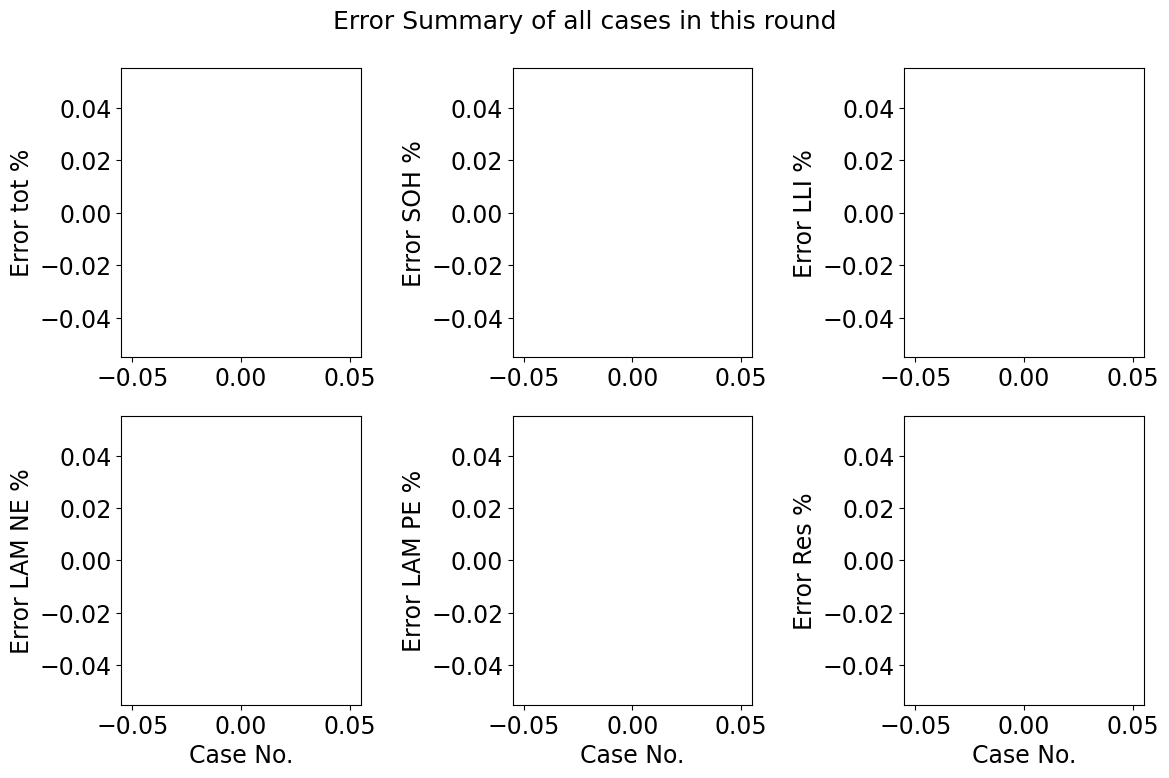

In [12]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.png", dpi=600)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.svg")

In [13]:
Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
